In [1]:
from artemis import artemis

# Basic example
Pre-requisities
```
artemis
numpy
scipy
pandas
```

In [2]:
import numpy as np
from scipy import sparse
import pandas as pd

### Generate data

In [3]:
# set the random seed
np.random.seed(1)

# Assign simulation parameters
n = 10000 # Number of samples (n_samples)
p = 100 # Number of features (genes)
p_X = 0.05 # Probability of a variant in a given gene

# Generate features
X = 1*(np.random.rand(n,p)<=p_X)

# Assign gene names (could be anything, here we opt for 'gene_0', 'gene_1' etc.)
gene_names = [f'gene_{i}' for i in range(p)]

# Generate phenotype labels from the first p0 features
p0 = 5
y = (X[:,:p0].sum(axis=1)>=1)

### Perform inference

0:00:02.644887


<Axes: title={'center': 'Gene PIPs'}, xlabel='gene', ylabel='PIP value'>

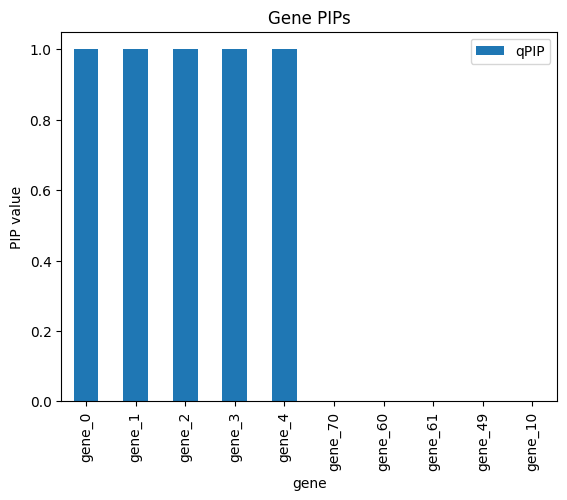

In [4]:
# Initialise the variational inference module
vb = artemis.VB(
    sparse.csr_matrix(X), # converts the numpy array to a sparse matrix
    gene_names, # name of genes corresponding to each column of the sparse matrix
    y # phenotype labels (should be a binary vector of length n_samples)
)

# Run variational inference (n_rep=number of iterations)
vb.run(n_rep=3)

# Plot the top 10 values
vb.qpip_df[:10].plot(kind='bar', xlabel='gene', ylabel='PIP value', title='Gene PIPs')

# XOR example
We also explore what happens when the phenotype label depends on the first two features through an XOR operation

In [5]:
# Generate new data using an XOR process
y = (X[:,:2].sum(axis=1)==1)

0:00:02.624217


<Axes: title={'center': 'Gene PIPs'}, xlabel='gene', ylabel='PIP value'>

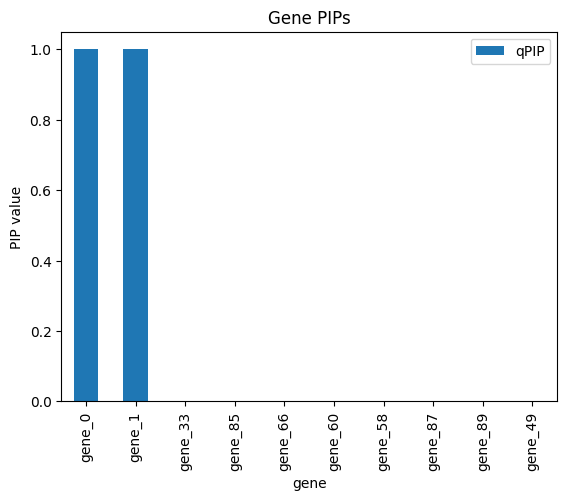

In [6]:
# Run ARTEMIS again
vb = artemis.VB(
    sparse.csr_matrix(X), 
    gene_names, 
    y
)
vb.run(n_rep=3)
vb.qpip_df[:10].plot(kind='bar', xlabel='gene', ylabel='PIP value', title='Gene PIPs')

# Example pipeline
- Here, we resample cases and controls according to a stratified sampling routine
- For each sample of cases and controls we perform variational Bayes inference in the model
- This generates a set of PIPs for each gene for a given sub-sample
- PIPs are then averaged to obtain a single measure of Bayesian importance for each gene

Processing of this part may take a few minutes (~5mins on this test)

The **first five** genes are the only ones associated to the phenotype from the synthetic data

In [7]:
cov_df = pd.read_csv('synthetic_data/cov.csv.gz', index_col=0)
X_df = pd.read_csv('synthetic_data/X.csv.gz', index_col=0)
y_df = pd.read_csv('synthetic_data/y.csv.gz', index_col=0).pheno
X_df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_990,gene_991,gene_992,gene_993,gene_994,gene_995,gene_996,gene_997,gene_998,gene_999
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
n_samplings = 10
pip_dfs = {}

for subsample in range(n_samplings):

    print(f'Running cohort sample: {subsample+1} of {n_samplings}')
    
    age_sex = cov_df.copy()
    cases = y_df[y_df==1].index
    controls = y_df[y_df==0].index
    
    # Bin age covariate into 4 bins
    age_sex['age'] = pd.qcut(age_sex['age'], 4)
    
    # stratify resample cases and controls by age and sex
    stratified_df = artemis.stratified_sample( age_sex.loc[controls], age_sex.loc[cases], ['age','sex'])
    stratified_df['case'] = stratified_df.index.map(lambda x: x in cases)*1
    
    # Run ARTEMIS with new cohort
    X_df_in = X_df.loc[stratified_df.index]
    y_df_in = stratified_df.case
    
    vb = artemis.VB(
        sparse.csc_matrix(X_df_in.values), 
        X_df_in.columns, 
        y_df_in,
        verbose=True
    )
    vb.run(n_rep=3)
    pip_dfs[f'iter_{subsample}'] = vb.qpip_df

pip_df = pd.concat(pip_dfs, axis=1).mean(axis=1).rename('pip').to_frame()

pip_df[:20]

Running cohort sample: 1 of 10
0:00:26.977839
Running cohort sample: 2 of 10
0:00:26.732903
Running cohort sample: 3 of 10
0:00:26.880314
Running cohort sample: 4 of 10
0:00:27.026876
Running cohort sample: 5 of 10
0:00:26.978402
Running cohort sample: 6 of 10
0:00:26.941626
Running cohort sample: 7 of 10
0:00:26.777696
Running cohort sample: 8 of 10
0:00:26.928300
Running cohort sample: 9 of 10
0:00:26.967927
Running cohort sample: 10 of 10
0:00:26.766663


,pip
gene_1,1.000000
gene_3,1.000000
gene_4,1.000000
gene_2,1.000000
gene_0,1.000000
gene_213,0.029380
gene_110,0.011586
gene_284,0.015564
gene_794,0.018438
gene_174,0.022750


<Axes: title={'center': 'Gene PIPs'}, xlabel='gene', ylabel='PIP value'>

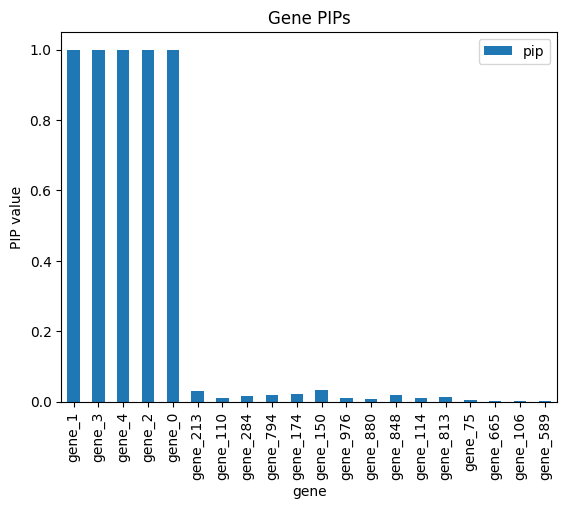

In [9]:
pip_df[:20].plot(kind='bar', xlabel='gene', ylabel='PIP value', title='Gene PIPs')